# Đọc và tiền xử lí dữ liệu

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Đọc dữ liệu vào từ file csv
data = pd.read_csv('ACB Historical Data.csv', index_col='Date', parse_dates=True)

# Chọn các cột 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %' cho model VAR
cols = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
data = data[cols]

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data = data.reset_index(drop=True)
data

,Price,Open,High,Low,Vol.,Change %
0,10537.7,10477.8,10567.6,10417.9,7360000,0.0086
1,10926.9,10537.7,10956.8,10537.7,9450000,0.0369
2,10477.8,10956.8,10956.8,10477.8,8189999,-0.0411
3,10447.9,10447.9,10627.5,10328.1,9810000,-0.0029
4,10837.1,10447.9,10837.1,10447.9,8300000,0.0373
...,...,...,...,...,...,...
1373,21450.0,21650.0,21650.0,21350.0,4290000,-0.0046
1374,21600.0,21500.0,21600.0,21400.0,7970000,0.0070
1375,21650.0,21650.0,21900.0,21600.0,8029999,0.0023
1376,21700.0,21650.0,21700.0,21550.0,5410000,0.0023


# Phân chia dữ liệu

In [2]:
# Tách dữ liệu thành tập train/test/validate
train_size = int(len(data) * 0.8)
test_size = int(len(data) * 0.15)
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [3]:
# Chuyển đổi dữ liệu thành dạng ma trận
train_X = train_data.values
train_y = train_data['Price'].values

val_X = val_data.values
val_y = val_data['Price'].values

test_X = test_data.values
test_y = test_data['Price'].values

# Xây dựng mô hình và train

In [4]:
# Xác định số lượng lags tối ưu
best_p = 0
best_rmse = float('inf')

for p in range(1, 6):
    model = VAR(train_X)
    results = model.fit(p)
    
    val_pred = results.forecast(train_X[-p:], len(val_X))
    rmse = np.sqrt(mean_squared_error(val_y, val_pred[:, 0]))
    print(f'p={p}, RMSE={rmse}')
    if rmse < best_rmse:
        best_p = p
        best_rmse = rmse

# Huấn luyện model VAR trên toàn bộ tập train với số lượng lags tối ưu
model = VAR(train_X)
results = model.fit(best_p)

p=1, RMSE=1727.406740299635
p=2, RMSE=1732.7294886685927
p=3, RMSE=1662.9346431172955
p=4, RMSE=1711.1725184400582
p=5, RMSE=1647.3622822394873


# Dự báo trên tập test / validate và đánh giá mô hình

In [5]:
# Dự đoán giá trị trên tập test và validate
test_pred = results.forecast(test_X[-best_p:], len(test_X))
val_pred = results.forecast(val_X[-best_p:], len(val_X))

In [6]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE, MDA trên tập test
test_score_rmse = np.sqrt(mean_squared_error(test_y, test_pred[:, 0]))
test_score_mape = mean_absolute_percentage_error(test_y, test_pred[:, 0]) * 100
test_score_mda = calculate_mda(test_y, test_pred[:, 0])


print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 2399.437802484789
MAPE trên tập test là: 8.160452384227645 %
MDA trên tập test là: 48.292682926829265 %


# Dự báo 30 ngày tiếp theo

In [7]:
# Tạo hàm dự báo 30 ngày tương lai, với k_ar là thuộc tính của results VAR thể hiện số lượng lags tối ưu
def forecast_VAR(results, val_data, forecast_horizon=30):

    forecast = results.forecast(val_data.values[-results.k_ar:], forecast_horizon)

    return forecast

In [8]:
# Dự báo tương lai
next_30_days = forecast_VAR(results, val_data)
print(next_30_days[:,1])

[21856.00887779 21878.03894981 21877.89076711 21931.1971026
 21871.27625543 21913.40003894 21910.53447323 21926.8022975
 21932.87504505 21945.49934568 21952.2475371  21963.05184143
 21971.18319033 21980.36354875 21988.93557614 21997.81703794
 22006.45546777 22015.10827035 22023.68430367 22032.20223071
 22040.69580174 22049.14115988 22057.54843607 22065.92251452
 22074.26201254 22082.57292368 22090.85430256 22099.10938131
 22107.33930166 22115.54587802]


# Chuyển các chuỗi np thành dataframe để vẽ đồ thị

In [9]:
next_30_days_df = pd.DataFrame(next_30_days[:,1])
next_30_index = range(len(data), len(data)+len(next_30_days[:,1]))
next_30_days_df.index = next_30_index

# Vẽ đồ thị

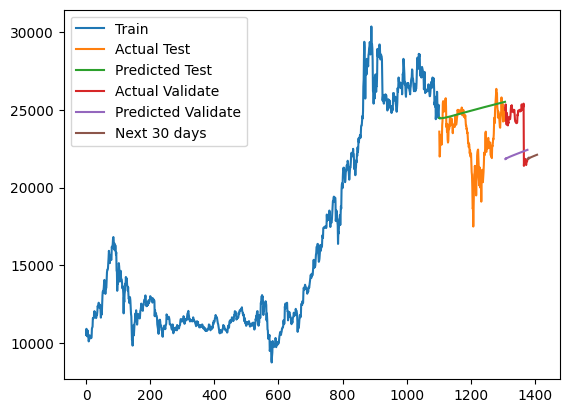

In [10]:
# Vẽ đồ thị cho dữ liệu thực tế và dự đoán trên tập test
plt.plot(train_data.index, train_data['Price'], label='Train')
plt.plot(test_data.index, test_data['Price'], label='Actual Test')
plt.plot(test_data.index, test_pred[:, 0], label='Predicted Test')
plt.plot(val_data.index, val_data['Price'], label='Actual Validate')
plt.plot(val_data.index, val_pred[:, 0], label='Predicted Validate')
plt.plot(next_30_days_df.index, next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()